In [2]:
!pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize

from datasets import load_dataset
from collections import Counter
import re

In [4]:
nltk.download('punkt_tab')
torch.manual_seed(13)
np.random.seed(13)

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## LSTM
1. Choose a dataset
2. Download and check the shape of the dataset
3. Clean the data if needed
4. Decide the tokenization strategy
5. Build the vocab
6. Build a wrapper around the dataset
7. Dataloader -> train[0] (input, label)
8. Build network architecture
9. Training loop
10. Evaluate

### Choosse a dataset

In [5]:
dataset = load_dataset("imdb")

train_data = dataset['train']
test_data = dataset['test']

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data size: 25000
Test data size: 25000
Train data shape: (25000, 2)
Test data shape: (25000, 2)


In [7]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

Well, the fact that I myself can't decide if that's a good or bad review is laughable. I don't know what label 0 mean.

In [8]:
train_data[13]

{'text': "Its not the cast. A finer group of actors, you could not find. Its not the setting. The director is in love with New York City, and by the end of the film, so are we all! Woody Allen could not improve upon what Bogdonovich has done here. If you are going to fall in love, or find love, Manhattan is the place to go. No, the problem with the movie is the script. There is none. The actors fall in love at first sight, words are unnecessary. In the director's own experience in Hollywood that is what happens when they go to work on the set. It is reality to him, and his peers, but it is a fantasy to most of us in the real world. So, in the end, the movie is hollow, and shallow, and message-less.",
 'label': 0}

That settles it then, 0 means bad, 1 means good. right?

In [9]:
labels = {}
for i in train_data:
  labels[i['label']] = labels.get(i['label'], 0) + 1
print(labels)

{0: 12500, 1: 12500}


Yes, prefectly balanced as well. Good signs.

### Clean the data

In [10]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text) # To remove any html tags
    text = re.sub(r'[^a-z0-9\s]', '', text) # To remove any special characters
    tokens = word_tokenize(text)
    return tokens

preprocess_text('testing the function, \'by\' test text.')

['testing', 'the', 'function', 'by', 'test', 'text']

In [11]:
train_reviews = []
train_labels = []
for sample in train_data:
  train_reviews.append(preprocess_text(sample['text']))
  train_labels.append(sample['label'])


test_reviews = []
test_labels = []
for sample in test_data:
  test_reviews.append(preprocess_text(sample['text']))
  test_labels.append(sample['label'])

print('Text', train_reviews[0], '\nLabel', train_labels[0])

Text ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myselfthe', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'united', 'states', '

### Build the vocab

In [12]:
def build_vocab(reviews, max_words=10000):
    word_count = Counter()

    for review in reviews:
        word_count.update(review)

    most_common = word_count.most_common(max_words - 2)
    vocab = {word: i + 2 for i, (word, _) in enumerate(most_common)}

    vocab['<pad>'] = 0
    vocab['<unk>'] = 1

    return vocab

vocab = build_vocab(train_reviews)
vocab_size = len(vocab)

print('vocab size:', vocab_size)
print(list(vocab.items())[:5])

vocab size: 10000
[('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6)]


Maximum review length: 2450
Mean review length: 228.84
Median review length: 171.0
95th percentile length: 585.0


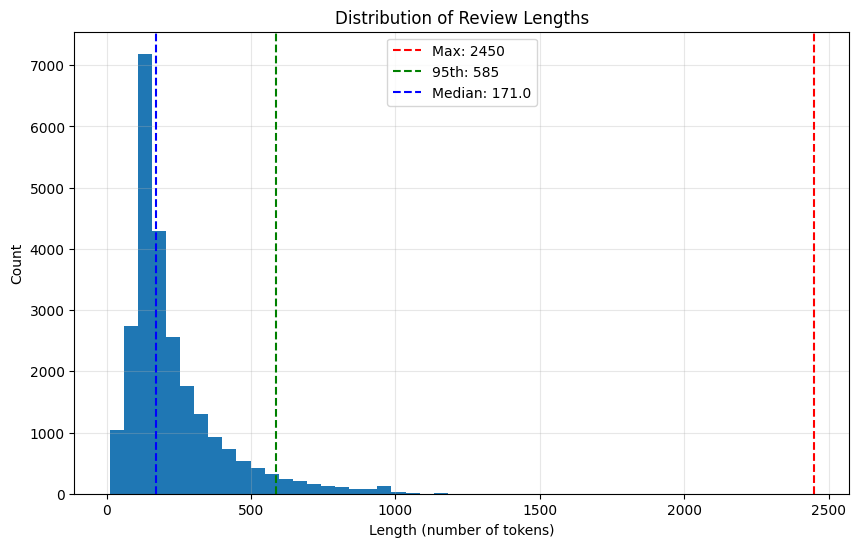

torch.Size([25000, 585]) torch.Size([25000]) torch.Size([25000, 585]) torch.Size([25000])


In [13]:
# Analyze review lengths to determine optimal max_len
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

def encode_review(review, vocabm, max_len=500):
    encoded = [vocab.get(word, vocab['<unk>']) for word in review[:max_len]]

    if len(encoded) < max_len:
        encoded += [vocab['<pad>']] * (max_len - len(encoded))

    return encoded

# Encode
train_encoded = [encode_review(review, vocab, int(p95_length)) for review in train_reviews]
test_encoded = [encode_review(review, vocab, int(p95_length)) for review in test_reviews]

# Convert
train_encoded = torch.tensor(train_encoded, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.float)
test_encoded = torch.tensor(test_encoded, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.float)

print(train_encoded.shape, train_labels.shape, test_encoded.shape, test_labels.shape)

### Build a wrapper and Data loader

In [14]:
from sklearn.model_selection import train_test_split

class ImdbDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        return review, label


train_seq, val_seq, train_label, val_label = train_test_split(train_encoded, train_labels, test_size=0.2, random_state=13)
train_dataset = ImdbDataset(train_seq, train_label)
val_dataset = ImdbDataset(val_seq, val_label)
test_dataset = ImdbDataset(test_encoded, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f'Train loader size: {len(train_loader)}')


Train loader size: 157


### Build network architecture


In [75]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, bidirectional=False, layer_norm=False, dropout=0.0):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout,
                            batch_first=True)

        self.layer_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim) if layer_norm else None

        self.dropout = nn.Dropout(dropout) if dropout else dropout

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
    
        hidden = self.layer_norm(hidden) if self.layer_norm else hidden

        return self.fc(hidden)



In [16]:
# Model
model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=False,
    layer_norm=False,
    dropout = 0.0
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Train one epoch
def trainOneEpoch(model, criterion, optimizer, loader, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for reviews, labels in loader:
        reviews, labels = reviews.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(reviews).squeeze(1)

        loss = criterion(predictions, labels)

        # Calculate accuracy
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct =  (predicted_classes == labels).float()
        acc = correct.sum() / len(correct)

        loss.backward()
        optimizer.step()

        epoch_acc += acc.item()
        epoch_loss += loss.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Validate
def validate(model, criterion, loader, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for reviews, labels in loader:
            reviews, labels = reviews.to(device), labels.to(device)

            predictions = model(reviews).squeeze(1)

            loss = criterion(predictions, labels)

            # Calculate accuracy
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct =  (predicted_classes == labels).float()
            acc = correct.sum() / len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)



In [18]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:05<00:23,  5.85s/it]

Epoch: 01
	Train Loss: 0.694	Train Acc: 0.501
	 Val. Loss: 0.693	Val. Acc: 0.503


 40%|████      | 2/5 [00:10<00:15,  5.31s/it]

Epoch: 02
	Train Loss: 0.692	Train Acc: 0.498
	 Val. Loss: 0.692	Val. Acc: 0.505


 60%|██████    | 3/5 [00:15<00:10,  5.16s/it]

Epoch: 03
	Train Loss: 0.689	Train Acc: 0.510
	 Val. Loss: 0.693	Val. Acc: 0.501


 80%|████████  | 4/5 [00:20<00:05,  5.13s/it]

Epoch: 04
	Train Loss: 0.681	Train Acc: 0.514
	 Val. Loss: 0.697	Val. Acc: 0.502


100%|██████████| 5/5 [00:25<00:00,  5.20s/it]

Epoch: 05
	Train Loss: 0.673	Train Acc: 0.523
	 Val. Loss: 0.704	Val. Acc: 0.502


Let's try 10 more epochs

In [18]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:05<00:50,  5.57s/it]

Epoch: 01
	Train Loss: 0.664	Train Acc: 0.528
	 Val. Loss: 0.712	Val. Acc: 0.503


 20%|██        | 2/10 [00:11<00:44,  5.59s/it]

Epoch: 02
	Train Loss: 0.661	Train Acc: 0.523
	 Val. Loss: 0.721	Val. Acc: 0.508


 30%|███       | 3/10 [00:16<00:39,  5.66s/it]

Epoch: 03
	Train Loss: 0.659	Train Acc: 0.523
	 Val. Loss: 0.722	Val. Acc: 0.502


 40%|████      | 4/10 [00:22<00:34,  5.71s/it]

Epoch: 04
	Train Loss: 0.608	Train Acc: 0.644
	 Val. Loss: 0.625	Val. Acc: 0.657


 50%|█████     | 5/10 [00:28<00:28,  5.77s/it]

Epoch: 05
	Train Loss: 0.515	Train Acc: 0.757
	 Val. Loss: 0.514	Val. Acc: 0.778


 60%|██████    | 6/10 [00:34<00:23,  5.84s/it]

Epoch: 06
	Train Loss: 0.395	Train Acc: 0.836
	 Val. Loss: 0.422	Val. Acc: 0.830


 70%|███████   | 7/10 [00:40<00:17,  5.91s/it]

Epoch: 07
	Train Loss: 0.305	Train Acc: 0.880
	 Val. Loss: 0.408	Val. Acc: 0.826


 80%|████████  | 8/10 [00:46<00:11,  5.99s/it]

Epoch: 08
	Train Loss: 0.253	Train Acc: 0.905
	 Val. Loss: 0.383	Val. Acc: 0.854


 90%|█████████ | 9/10 [00:53<00:06,  6.07s/it]

Epoch: 09
	Train Loss: 0.216	Train Acc: 0.921
	 Val. Loss: 0.396	Val. Acc: 0.844


100%|██████████| 10/10 [00:59<00:00,  5.94s/it]

Epoch: 10
	Train Loss: 0.177	Train Acc: 0.939
	 Val. Loss: 0.407	Val. Acc: 0.845


In [20]:
# Model
model2 = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=False,
    layer_norm=False,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0009)

In [22]:
epochs = 25

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model2, criterion, optimizer2, train_loader, device)
    val_loss, val_acc = validate(model2, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

  4%|▍         | 1/25 [00:06<02:27,  6.13s/it]

Epoch: 01
	Train Loss: 0.388	Train Acc: 0.844
	 Val. Loss: 0.454	Val. Acc: 0.808


  8%|▊         | 2/25 [00:12<02:21,  6.16s/it]

Epoch: 02
	Train Loss: 0.325	Train Acc: 0.874
	 Val. Loss: 0.433	Val. Acc: 0.828


 12%|█▏        | 3/25 [00:18<02:17,  6.24s/it]

Epoch: 03
	Train Loss: 0.383	Train Acc: 0.849
	 Val. Loss: 0.532	Val. Acc: 0.766


 16%|█▌        | 4/25 [00:25<02:13,  6.36s/it]

Epoch: 04
	Train Loss: 0.593	Train Acc: 0.724
	 Val. Loss: 0.635	Val. Acc: 0.672


 20%|██        | 5/25 [00:31<02:08,  6.45s/it]

Epoch: 05
	Train Loss: 0.574	Train Acc: 0.729
	 Val. Loss: 0.602	Val. Acc: 0.707


 24%|██▍       | 6/25 [00:38<02:02,  6.43s/it]

Epoch: 06
	Train Loss: 0.586	Train Acc: 0.686
	 Val. Loss: 0.566	Val. Acc: 0.756


 28%|██▊       | 7/25 [00:44<01:55,  6.40s/it]

Epoch: 07
	Train Loss: 0.474	Train Acc: 0.806
	 Val. Loss: 0.500	Val. Acc: 0.793


 32%|███▏      | 8/25 [00:50<01:47,  6.35s/it]

Epoch: 08
	Train Loss: 0.386	Train Acc: 0.858
	 Val. Loss: 0.468	Val. Acc: 0.807


 36%|███▌      | 9/25 [00:56<01:40,  6.30s/it]

Epoch: 09
	Train Loss: 0.333	Train Acc: 0.879
	 Val. Loss: 0.451	Val. Acc: 0.823


 40%|████      | 10/25 [01:03<01:33,  6.24s/it]

Epoch: 10
	Train Loss: 0.335	Train Acc: 0.880
	 Val. Loss: 0.436	Val. Acc: 0.826


 44%|████▍     | 11/25 [01:09<01:26,  6.19s/it]

Epoch: 11
	Train Loss: 0.278	Train Acc: 0.902
	 Val. Loss: 0.445	Val. Acc: 0.833


 48%|████▊     | 12/25 [01:15<01:20,  6.16s/it]

Epoch: 12
	Train Loss: 0.248	Train Acc: 0.917
	 Val. Loss: 0.442	Val. Acc: 0.831


 52%|█████▏    | 13/25 [01:21<01:13,  6.12s/it]

Epoch: 13
	Train Loss: 0.221	Train Acc: 0.930
	 Val. Loss: 0.456	Val. Acc: 0.832


 56%|█████▌    | 14/25 [01:27<01:07,  6.10s/it]

Epoch: 14
	Train Loss: 0.203	Train Acc: 0.938
	 Val. Loss: 0.454	Val. Acc: 0.835


 60%|██████    | 15/25 [01:33<01:00,  6.09s/it]

Epoch: 15
	Train Loss: 0.184	Train Acc: 0.947
	 Val. Loss: 0.467	Val. Acc: 0.834


 64%|██████▍   | 16/25 [01:39<00:54,  6.09s/it]

Epoch: 16
	Train Loss: 0.187	Train Acc: 0.945
	 Val. Loss: 0.466	Val. Acc: 0.842


 68%|██████▊   | 17/25 [01:45<00:48,  6.09s/it]

Epoch: 17
	Train Loss: 0.166	Train Acc: 0.954
	 Val. Loss: 0.466	Val. Acc: 0.842


 72%|███████▏  | 18/25 [01:51<00:42,  6.11s/it]

Epoch: 18
	Train Loss: 0.177	Train Acc: 0.949
	 Val. Loss: 0.481	Val. Acc: 0.830


 76%|███████▌  | 19/25 [01:57<00:36,  6.12s/it]

Epoch: 19
	Train Loss: 0.152	Train Acc: 0.959
	 Val. Loss: 0.486	Val. Acc: 0.837


 80%|████████  | 20/25 [02:04<00:30,  6.14s/it]

Epoch: 20
	Train Loss: 0.136	Train Acc: 0.966
	 Val. Loss: 0.494	Val. Acc: 0.846


 84%|████████▍ | 21/25 [02:10<00:24,  6.14s/it]

Epoch: 21
	Train Loss: 0.142	Train Acc: 0.962
	 Val. Loss: 0.510	Val. Acc: 0.837


 88%|████████▊ | 22/25 [02:16<00:18,  6.14s/it]

Epoch: 22
	Train Loss: 0.137	Train Acc: 0.965
	 Val. Loss: 0.505	Val. Acc: 0.830


 92%|█████████▏| 23/25 [02:22<00:12,  6.14s/it]

Epoch: 23
	Train Loss: 0.146	Train Acc: 0.959
	 Val. Loss: 0.529	Val. Acc: 0.831


 96%|█████████▌| 24/25 [02:28<00:06,  6.13s/it]

Epoch: 24
	Train Loss: 0.117	Train Acc: 0.972
	 Val. Loss: 0.517	Val. Acc: 0.838


100%|██████████| 25/25 [02:34<00:00,  6.19s/it]

Epoch: 25
	Train Loss: 0.163	Train Acc: 0.956
	 Val. Loss: 0.541	Val. Acc: 0.832


In [25]:
# Model
model_with_layer_norm = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=False,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_layer_norm = torch.optim.Adam(model_with_layer_norm.parameters(), lr=0.001)

In [26]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_layer_norm, criterion, optimizer_layer_norm, train_loader, device)
    val_loss, val_acc = validate(model_with_layer_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:06<00:25,  6.26s/it]

Epoch: 01
	Train Loss: 0.700	Train Acc: 0.496
	 Val. Loss: 0.701	Val. Acc: 0.500


 40%|████      | 2/5 [00:12<00:18,  6.33s/it]

Epoch: 02
	Train Loss: 0.692	Train Acc: 0.507
	 Val. Loss: 0.701	Val. Acc: 0.500


 60%|██████    | 3/5 [00:19<00:12,  6.38s/it]

Epoch: 03
	Train Loss: 0.686	Train Acc: 0.508
	 Val. Loss: 0.696	Val. Acc: 0.502


 80%|████████  | 4/5 [00:25<00:06,  6.38s/it]

Epoch: 04
	Train Loss: 0.678	Train Acc: 0.516
	 Val. Loss: 0.699	Val. Acc: 0.505


100%|██████████| 5/5 [00:31<00:00,  6.35s/it]

Epoch: 05
	Train Loss: 0.669	Train Acc: 0.522
	 Val. Loss: 0.705	Val. Acc: 0.505


In [27]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_layer_norm, criterion, optimizer_layer_norm, train_loader, device)
    val_loss, val_acc = validate(model_with_layer_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:06<00:57,  6.37s/it]

Epoch: 01
	Train Loss: 0.664	Train Acc: 0.523
	 Val. Loss: 0.713	Val. Acc: 0.506


 20%|██        | 2/10 [00:12<00:51,  6.47s/it]

Epoch: 02
	Train Loss: 0.660	Train Acc: 0.527
	 Val. Loss: 0.717	Val. Acc: 0.504


 30%|███       | 3/10 [00:19<00:46,  6.60s/it]

Epoch: 03
	Train Loss: 0.659	Train Acc: 0.528
	 Val. Loss: 0.723	Val. Acc: 0.503


 40%|████      | 4/10 [00:26<00:39,  6.60s/it]

Epoch: 04
	Train Loss: 0.659	Train Acc: 0.526
	 Val. Loss: 0.736	Val. Acc: 0.504


 50%|█████     | 5/10 [00:32<00:32,  6.52s/it]

Epoch: 05
	Train Loss: 0.659	Train Acc: 0.526
	 Val. Loss: 0.740	Val. Acc: 0.506


 60%|██████    | 6/10 [00:38<00:25,  6.43s/it]

Epoch: 06
	Train Loss: 0.660	Train Acc: 0.521
	 Val. Loss: 0.720	Val. Acc: 0.508


 70%|███████   | 7/10 [00:45<00:19,  6.34s/it]

Epoch: 07
	Train Loss: 0.661	Train Acc: 0.523
	 Val. Loss: 0.725	Val. Acc: 0.503


 80%|████████  | 8/10 [00:51<00:12,  6.25s/it]

Epoch: 08
	Train Loss: 0.661	Train Acc: 0.521
	 Val. Loss: 0.731	Val. Acc: 0.508


 90%|█████████ | 9/10 [00:57<00:06,  6.19s/it]

Epoch: 09
	Train Loss: 0.610	Train Acc: 0.656
	 Val. Loss: 0.608	Val. Acc: 0.696


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]

Epoch: 10
	Train Loss: 0.488	Train Acc: 0.776
	 Val. Loss: 0.519	Val. Acc: 0.764


In [28]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_layer_norm, criterion, optimizer_layer_norm, train_loader, device)
    val_loss, val_acc = validate(model_with_layer_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:06<00:24,  6.09s/it]

Epoch: 01
	Train Loss: 0.373	Train Acc: 0.844
	 Val. Loss: 0.434	Val. Acc: 0.817


 40%|████      | 2/5 [00:12<00:18,  6.12s/it]

Epoch: 02
	Train Loss: 0.294	Train Acc: 0.889
	 Val. Loss: 0.427	Val. Acc: 0.838


 60%|██████    | 3/5 [00:18<00:12,  6.20s/it]

Epoch: 03
	Train Loss: 0.241	Train Acc: 0.911
	 Val. Loss: 0.465	Val. Acc: 0.801


 80%|████████  | 4/5 [00:24<00:06,  6.30s/it]

Epoch: 04
	Train Loss: 0.204	Train Acc: 0.928
	 Val. Loss: 0.433	Val. Acc: 0.835


100%|██████████| 5/5 [00:31<00:00,  6.31s/it]

Epoch: 05
	Train Loss: 0.157	Train Acc: 0.948
	 Val. Loss: 0.463	Val. Acc: 0.843


In [29]:
# Model
model_with_2layers = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    bidirectional=False,
    layer_norm=False,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_2layers = torch.optim.Adam(model_with_2layers.parameters(), lr=0.01)

In [30]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_2layers, criterion, optimizer_2layers, train_loader, device)
    val_loss, val_acc = validate(model_with_2layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:11<00:47, 11.85s/it]

Epoch: 01
	Train Loss: 0.696	Train Acc: 0.505
	 Val. Loss: 0.693	Val. Acc: 0.501


 40%|████      | 2/5 [00:23<00:35, 11.91s/it]

Epoch: 02
	Train Loss: 0.692	Train Acc: 0.502
	 Val. Loss: 0.694	Val. Acc: 0.502


 60%|██████    | 3/5 [00:35<00:23, 11.85s/it]

Epoch: 03
	Train Loss: 0.685	Train Acc: 0.514
	 Val. Loss: 0.701	Val. Acc: 0.502


 80%|████████  | 4/5 [00:47<00:11, 11.80s/it]

Epoch: 04
	Train Loss: 0.672	Train Acc: 0.523
	 Val. Loss: 0.712	Val. Acc: 0.503


100%|██████████| 5/5 [00:58<00:00, 11.79s/it]

Epoch: 05
	Train Loss: 0.662	Train Acc: 0.552
	 Val. Loss: 0.643	Val. Acc: 0.676


okay, 10 more epochs

In [31]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_2layers, criterion, optimizer_2layers, train_loader, device)
    val_loss, val_acc = validate(model_with_2layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:12<01:51, 12.43s/it]

Epoch: 01
	Train Loss: 0.606	Train Acc: 0.690
	 Val. Loss: 0.586	Val. Acc: 0.728


 20%|██        | 2/10 [00:25<01:40, 12.60s/it]

Epoch: 02
	Train Loss: 0.612	Train Acc: 0.660
	 Val. Loss: 0.697	Val. Acc: 0.506


 30%|███       | 3/10 [00:37<01:26, 12.39s/it]

Epoch: 03
	Train Loss: 0.581	Train Acc: 0.688
	 Val. Loss: 0.482	Val. Acc: 0.790


 40%|████      | 4/10 [00:49<01:13, 12.21s/it]

Epoch: 04
	Train Loss: 0.437	Train Acc: 0.816
	 Val. Loss: 0.451	Val. Acc: 0.807


 50%|█████     | 5/10 [01:00<01:00, 12.03s/it]

Epoch: 05
	Train Loss: 0.362	Train Acc: 0.854
	 Val. Loss: 0.427	Val. Acc: 0.823


 60%|██████    | 6/10 [01:12<00:47, 11.92s/it]

Epoch: 06
	Train Loss: 0.305	Train Acc: 0.884
	 Val. Loss: 0.445	Val. Acc: 0.821


 70%|███████   | 7/10 [01:24<00:35, 11.87s/it]

Epoch: 07
	Train Loss: 0.280	Train Acc: 0.891
	 Val. Loss: 0.415	Val. Acc: 0.828


 80%|████████  | 8/10 [01:36<00:23, 11.89s/it]

Epoch: 08
	Train Loss: 0.233	Train Acc: 0.915
	 Val. Loss: 0.429	Val. Acc: 0.827


 90%|█████████ | 9/10 [01:48<00:11, 11.93s/it]

Epoch: 09
	Train Loss: 0.196	Train Acc: 0.931
	 Val. Loss: 0.437	Val. Acc: 0.838


100%|██████████| 10/10 [02:00<00:00, 12.04s/it]

Epoch: 10
	Train Loss: 0.171	Train Acc: 0.940
	 Val. Loss: 0.407	Val. Acc: 0.842


In [32]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_2layers, criterion, optimizer_2layers, train_loader, device)
    val_loss, val_acc = validate(model_with_2layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:11<00:47, 11.93s/it]

Epoch: 01
	Train Loss: 0.137	Train Acc: 0.955
	 Val. Loss: 0.461	Val. Acc: 0.834


 40%|████      | 2/5 [00:24<00:36, 12.24s/it]

Epoch: 02
	Train Loss: 0.130	Train Acc: 0.954
	 Val. Loss: 0.461	Val. Acc: 0.847


 60%|██████    | 3/5 [00:37<00:24, 12.45s/it]

Epoch: 03
	Train Loss: 0.131	Train Acc: 0.956
	 Val. Loss: 0.444	Val. Acc: 0.850


 80%|████████  | 4/5 [00:49<00:12, 12.31s/it]

Epoch: 04
	Train Loss: 0.107	Train Acc: 0.964
	 Val. Loss: 0.450	Val. Acc: 0.856


100%|██████████| 5/5 [01:01<00:00, 12.21s/it]

Epoch: 05
	Train Loss: 0.097	Train Acc: 0.969
	 Val. Loss: 0.453	Val. Acc: 0.851


I think it started to overfit slightly, let's try layer norm

In [35]:
# Model
model_with_2layers_with_norm = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    bidirectional=False,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_2layers_with_norm = torch.optim.Adam(model_with_2layers_with_norm.parameters(), lr=0.01)

In [36]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_2layers_with_norm, criterion, optimizer_2layers_with_norm, train_loader, device)
    val_loss, val_acc = validate(model_with_2layers_with_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:11<01:45, 11.73s/it]

Epoch: 01
	Train Loss: 0.708	Train Acc: 0.501
	 Val. Loss: 0.695	Val. Acc: 0.499


 20%|██        | 2/10 [00:23<01:35, 11.96s/it]

Epoch: 02
	Train Loss: 0.698	Train Acc: 0.498
	 Val. Loss: 0.693	Val. Acc: 0.505


 30%|███       | 3/10 [00:35<01:24, 12.03s/it]

Epoch: 03
	Train Loss: 0.691	Train Acc: 0.508
	 Val. Loss: 0.693	Val. Acc: 0.505


 40%|████      | 4/10 [00:47<01:12, 12.02s/it]

Epoch: 04
	Train Loss: 0.686	Train Acc: 0.511
	 Val. Loss: 0.703	Val. Acc: 0.501


 50%|█████     | 5/10 [00:59<00:59, 11.86s/it]

Epoch: 05
	Train Loss: 0.679	Train Acc: 0.514
	 Val. Loss: 0.700	Val. Acc: 0.504


 60%|██████    | 6/10 [01:11<00:46, 11.74s/it]

Epoch: 06
	Train Loss: 0.673	Train Acc: 0.525
	 Val. Loss: 0.704	Val. Acc: 0.504


 70%|███████   | 7/10 [01:22<00:34, 11.63s/it]

Epoch: 07
	Train Loss: 0.668	Train Acc: 0.521
	 Val. Loss: 0.721	Val. Acc: 0.506


 80%|████████  | 8/10 [01:33<00:23, 11.58s/it]

Epoch: 08
	Train Loss: 0.666	Train Acc: 0.529
	 Val. Loss: 0.716	Val. Acc: 0.504


 90%|█████████ | 9/10 [01:45<00:11, 11.56s/it]

Epoch: 09
	Train Loss: 0.665	Train Acc: 0.523
	 Val. Loss: 0.733	Val. Acc: 0.504


100%|██████████| 10/10 [01:57<00:00, 11.71s/it]

Epoch: 10
	Train Loss: 0.656	Train Acc: 0.579
	 Val. Loss: 0.684	Val. Acc: 0.645


5 epochs more

In [37]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_2layers_with_norm, criterion, optimizer_2layers_with_norm, train_loader, device)
    val_loss, val_acc = validate(model_with_2layers_with_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:12<01:51, 12.35s/it]

Epoch: 01
	Train Loss: 0.600	Train Acc: 0.682
	 Val. Loss: 0.593	Val. Acc: 0.704


 20%|██        | 2/10 [00:24<01:39, 12.48s/it]

Epoch: 02
	Train Loss: 0.575	Train Acc: 0.707
	 Val. Loss: 0.609	Val. Acc: 0.693


 30%|███       | 3/10 [00:36<01:26, 12.29s/it]

Epoch: 03
	Train Loss: 0.563	Train Acc: 0.721
	 Val. Loss: 0.602	Val. Acc: 0.667


 40%|████      | 4/10 [00:48<01:12, 12.04s/it]

Epoch: 04
	Train Loss: 0.512	Train Acc: 0.758
	 Val. Loss: 0.535	Val. Acc: 0.759


 50%|█████     | 5/10 [01:00<00:59, 11.83s/it]

Epoch: 05
	Train Loss: 0.473	Train Acc: 0.785
	 Val. Loss: 0.543	Val. Acc: 0.743


 60%|██████    | 6/10 [01:11<00:46, 11.67s/it]

Epoch: 06
	Train Loss: 0.445	Train Acc: 0.799
	 Val. Loss: 0.506	Val. Acc: 0.772


 70%|███████   | 7/10 [01:22<00:34, 11.58s/it]

Epoch: 07
	Train Loss: 0.436	Train Acc: 0.805
	 Val. Loss: 0.505	Val. Acc: 0.777


 80%|████████  | 8/10 [01:34<00:23, 11.56s/it]

Epoch: 08
	Train Loss: 0.415	Train Acc: 0.815
	 Val. Loss: 0.510	Val. Acc: 0.770


 90%|█████████ | 9/10 [01:46<00:11, 11.58s/it]

Epoch: 09
	Train Loss: 0.396	Train Acc: 0.829
	 Val. Loss: 0.540	Val. Acc: 0.751


100%|██████████| 10/10 [01:57<00:00, 11.77s/it]

Epoch: 10
	Train Loss: 0.396	Train Acc: 0.827
	 Val. Loss: 0.497	Val. Acc: 0.782


Let's try a model with 3 layers

In [38]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_2layers_with_norm, criterion, optimizer_2layers_with_norm, train_loader, device)
    val_loss, val_acc = validate(model_with_2layers_with_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:12<00:48, 12.21s/it]

Epoch: 01
	Train Loss: 0.366	Train Acc: 0.845
	 Val. Loss: 0.483	Val. Acc: 0.793


 40%|████      | 2/5 [00:24<00:36, 12.23s/it]

Epoch: 02
	Train Loss: 0.355	Train Acc: 0.849
	 Val. Loss: 0.496	Val. Acc: 0.785


 60%|██████    | 3/5 [00:36<00:24, 12.10s/it]

Epoch: 03
	Train Loss: 0.347	Train Acc: 0.856
	 Val. Loss: 0.482	Val. Acc: 0.796


 80%|████████  | 4/5 [00:47<00:11, 11.90s/it]

Epoch: 04
	Train Loss: 0.331	Train Acc: 0.863
	 Val. Loss: 0.495	Val. Acc: 0.793


100%|██████████| 5/5 [00:59<00:00, 11.88s/it]

Epoch: 05
	Train Loss: 0.344	Train Acc: 0.858
	 Val. Loss: 0.524	Val. Acc: 0.772


In [39]:
# Model
model_with_3layers = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=3,
    bidirectional=False,
    layer_norm=False,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_3layers = torch.optim.Adam(model_with_3layers.parameters(), lr=0.01)

In [40]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers, criterion, optimizer_3layers, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:18<01:12, 18.07s/it]

Epoch: 01
	Train Loss: 0.695	Train Acc: 0.503
	 Val. Loss: 0.693	Val. Acc: 0.504


 40%|████      | 2/5 [00:36<00:55, 18.47s/it]

Epoch: 02
	Train Loss: 0.693	Train Acc: 0.501
	 Val. Loss: 0.693	Val. Acc: 0.501


 60%|██████    | 3/5 [00:54<00:36, 18.05s/it]

Epoch: 03
	Train Loss: 0.691	Train Acc: 0.508
	 Val. Loss: 0.695	Val. Acc: 0.501


 80%|████████  | 4/5 [01:11<00:17, 17.75s/it]

Epoch: 04
	Train Loss: 0.684	Train Acc: 0.511
	 Val. Loss: 0.702	Val. Acc: 0.503


100%|██████████| 5/5 [01:28<00:00, 17.79s/it]

Epoch: 05
	Train Loss: 0.679	Train Acc: 0.515
	 Val. Loss: 0.699	Val. Acc: 0.502


In [41]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers, criterion, optimizer_3layers, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:17<02:40, 17.82s/it]

Epoch: 01
	Train Loss: 0.673	Train Acc: 0.516
	 Val. Loss: 0.717	Val. Acc: 0.499


 20%|██        | 2/10 [00:36<02:27, 18.45s/it]

Epoch: 02
	Train Loss: 0.671	Train Acc: 0.523
	 Val. Loss: 0.723	Val. Acc: 0.499


 30%|███       | 3/10 [00:54<02:07, 18.16s/it]

Epoch: 03
	Train Loss: 0.669	Train Acc: 0.520
	 Val. Loss: 0.729	Val. Acc: 0.498


 40%|████      | 4/10 [01:11<01:46, 17.81s/it]

Epoch: 04
	Train Loss: 0.666	Train Acc: 0.527
	 Val. Loss: 0.720	Val. Acc: 0.500


 50%|█████     | 5/10 [01:29<01:28, 17.62s/it]

Epoch: 05
	Train Loss: 0.665	Train Acc: 0.529
	 Val. Loss: 0.748	Val. Acc: 0.502


 60%|██████    | 6/10 [01:46<01:10, 17.51s/it]

Epoch: 06
	Train Loss: 0.663	Train Acc: 0.529
	 Val. Loss: 0.743	Val. Acc: 0.500


 70%|███████   | 7/10 [02:03<00:52, 17.48s/it]

Epoch: 07
	Train Loss: 0.663	Train Acc: 0.531
	 Val. Loss: 0.747	Val. Acc: 0.502


 80%|████████  | 8/10 [02:21<00:34, 17.49s/it]

Epoch: 08
	Train Loss: 0.662	Train Acc: 0.525
	 Val. Loss: 0.742	Val. Acc: 0.505


 90%|█████████ | 9/10 [02:38<00:17, 17.49s/it]

Epoch: 09
	Train Loss: 0.663	Train Acc: 0.523
	 Val. Loss: 0.745	Val. Acc: 0.502


100%|██████████| 10/10 [02:56<00:00, 17.62s/it]

Epoch: 10
	Train Loss: 0.661	Train Acc: 0.528
	 Val. Loss: 0.738	Val. Acc: 0.502


In [42]:
# Model
model_with_3layers = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=3,
    bidirectional=False,
    layer_norm=False,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_3layers = torch.optim.Adam(model_with_3layers.parameters(), lr=0.02)

In [44]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers, criterion, optimizer_3layers, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:17<02:39, 17.76s/it]

Epoch: 01
	Train Loss: 0.568	Train Acc: 0.699
	 Val. Loss: 0.664	Val. Acc: 0.616


 20%|██        | 2/10 [00:36<02:26, 18.35s/it]

Epoch: 02
	Train Loss: 0.546	Train Acc: 0.719
	 Val. Loss: 0.680	Val. Acc: 0.627


 30%|███       | 3/10 [00:54<02:06, 18.08s/it]

Epoch: 03
	Train Loss: 0.531	Train Acc: 0.735
	 Val. Loss: 0.663	Val. Acc: 0.630


 40%|████      | 4/10 [01:11<01:46, 17.77s/it]

Epoch: 04
	Train Loss: 0.529	Train Acc: 0.724
	 Val. Loss: 0.691	Val. Acc: 0.627


 50%|█████     | 5/10 [01:28<01:28, 17.60s/it]

Epoch: 05
	Train Loss: 0.536	Train Acc: 0.726
	 Val. Loss: 0.686	Val. Acc: 0.611


 60%|██████    | 6/10 [01:46<01:10, 17.50s/it]

Epoch: 06
	Train Loss: 0.530	Train Acc: 0.726
	 Val. Loss: 0.675	Val. Acc: 0.628


 70%|███████   | 7/10 [02:03<00:52, 17.45s/it]

Epoch: 07
	Train Loss: 0.513	Train Acc: 0.741
	 Val. Loss: 0.681	Val. Acc: 0.630


 80%|████████  | 8/10 [02:20<00:34, 17.43s/it]

Epoch: 08
	Train Loss: 0.503	Train Acc: 0.746
	 Val. Loss: 0.734	Val. Acc: 0.630


 90%|█████████ | 9/10 [02:38<00:17, 17.39s/it]

Epoch: 09
	Train Loss: 0.495	Train Acc: 0.752
	 Val. Loss: 0.675	Val. Acc: 0.626


100%|██████████| 10/10 [02:55<00:00, 17.55s/it]

Epoch: 10
	Train Loss: 0.480	Train Acc: 0.765
	 Val. Loss: 0.689	Val. Acc: 0.643


Trying normalizaion

In [45]:
# Model
model_with_3layers = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=3,
    bidirectional=False,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_3layers = torch.optim.Adam(model_with_3layers.parameters(), lr=0.005)

In [46]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers, criterion, optimizer_3layers, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:18<02:45, 18.37s/it]

Epoch: 01
	Train Loss: 0.713	Train Acc: 0.495
	 Val. Loss: 0.694	Val. Acc: 0.501


 20%|██        | 2/10 [00:36<02:27, 18.42s/it]

Epoch: 02
	Train Loss: 0.695	Train Acc: 0.499
	 Val. Loss: 0.693	Val. Acc: 0.504


 30%|███       | 3/10 [00:54<02:05, 17.92s/it]

Epoch: 03
	Train Loss: 0.694	Train Acc: 0.507
	 Val. Loss: 0.693	Val. Acc: 0.501


 40%|████      | 4/10 [01:11<01:45, 17.66s/it]

Epoch: 04
	Train Loss: 0.694	Train Acc: 0.506
	 Val. Loss: 0.707	Val. Acc: 0.501


 50%|█████     | 5/10 [01:28<01:27, 17.53s/it]

Epoch: 05
	Train Loss: 0.695	Train Acc: 0.505
	 Val. Loss: 0.694	Val. Acc: 0.498


 60%|██████    | 6/10 [01:46<01:09, 17.45s/it]

Epoch: 06
	Train Loss: 0.694	Train Acc: 0.506
	 Val. Loss: 0.696	Val. Acc: 0.499


 70%|███████   | 7/10 [02:03<00:52, 17.43s/it]

Epoch: 07
	Train Loss: 0.691	Train Acc: 0.506
	 Val. Loss: 0.699	Val. Acc: 0.505


 80%|████████  | 8/10 [02:20<00:34, 17.41s/it]

Epoch: 08
	Train Loss: 0.681	Train Acc: 0.517
	 Val. Loss: 0.704	Val. Acc: 0.523


 90%|█████████ | 9/10 [02:38<00:17, 17.41s/it]

Epoch: 09
	Train Loss: 0.662	Train Acc: 0.560
	 Val. Loss: 0.712	Val. Acc: 0.668


100%|██████████| 10/10 [02:55<00:00, 17.55s/it]

Epoch: 10
	Train Loss: 0.586	Train Acc: 0.713
	 Val. Loss: 0.583	Val. Acc: 0.735


10 more epochs

In [47]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers, criterion, optimizer_3layers, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:18<02:50, 18.89s/it]

Epoch: 01
	Train Loss: 0.587	Train Acc: 0.718
	 Val. Loss: 0.710	Val. Acc: 0.513


 20%|██        | 2/10 [00:37<02:29, 18.70s/it]

Epoch: 02
	Train Loss: 0.577	Train Acc: 0.704
	 Val. Loss: 0.589	Val. Acc: 0.735


 30%|███       | 3/10 [00:54<02:06, 18.11s/it]

Epoch: 03
	Train Loss: 0.533	Train Acc: 0.744
	 Val. Loss: 0.540	Val. Acc: 0.760


 40%|████      | 4/10 [01:12<01:46, 17.78s/it]

Epoch: 04
	Train Loss: 0.421	Train Acc: 0.829
	 Val. Loss: 0.433	Val. Acc: 0.816


 50%|█████     | 5/10 [01:29<01:28, 17.61s/it]

Epoch: 05
	Train Loss: 0.351	Train Acc: 0.860
	 Val. Loss: 0.402	Val. Acc: 0.823


 60%|██████    | 6/10 [01:46<01:10, 17.57s/it]

Epoch: 06
	Train Loss: 0.284	Train Acc: 0.893
	 Val. Loss: 0.377	Val. Acc: 0.851


 70%|███████   | 7/10 [02:04<00:52, 17.64s/it]

Epoch: 07
	Train Loss: 0.220	Train Acc: 0.921
	 Val. Loss: 0.370	Val. Acc: 0.851


 80%|████████  | 8/10 [02:22<00:35, 17.58s/it]

Epoch: 08
	Train Loss: 0.174	Train Acc: 0.942
	 Val. Loss: 0.380	Val. Acc: 0.854


 90%|█████████ | 9/10 [02:39<00:17, 17.51s/it]

Epoch: 09
	Train Loss: 0.132	Train Acc: 0.959
	 Val. Loss: 0.434	Val. Acc: 0.865


100%|██████████| 10/10 [02:56<00:00, 17.68s/it]

Epoch: 10
	Train Loss: 0.103	Train Acc: 0.971
	 Val. Loss: 0.469	Val. Acc: 0.858


In [48]:
# Model
model_with_3layers_norm_drop = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=3,
    bidirectional=False,
    layer_norm=True,
    dropout = 0.3
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_3layers_norm_drop = torch.optim.Adam(model_with_3layers_norm_drop.parameters(), lr=0.005)

In [49]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers_norm_drop, criterion, optimizer_3layers_norm_drop, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers_norm_drop, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:17<02:38, 17.62s/it]

Epoch: 01
	Train Loss: 0.712	Train Acc: 0.500
	 Val. Loss: 0.705	Val. Acc: 0.501


 20%|██        | 2/10 [00:36<02:25, 18.17s/it]

Epoch: 02
	Train Loss: 0.696	Train Acc: 0.498
	 Val. Loss: 0.693	Val. Acc: 0.504


 30%|███       | 3/10 [00:54<02:07, 18.21s/it]

Epoch: 03
	Train Loss: 0.695	Train Acc: 0.507
	 Val. Loss: 0.696	Val. Acc: 0.501


 40%|████      | 4/10 [01:12<01:48, 18.08s/it]

Epoch: 04
	Train Loss: 0.697	Train Acc: 0.503
	 Val. Loss: 0.700	Val. Acc: 0.504


 50%|█████     | 5/10 [01:30<01:29, 17.97s/it]

Epoch: 05
	Train Loss: 0.694	Train Acc: 0.506
	 Val. Loss: 0.694	Val. Acc: 0.504


 60%|██████    | 6/10 [01:47<01:11, 17.93s/it]

Epoch: 06
	Train Loss: 0.695	Train Acc: 0.502
	 Val. Loss: 0.693	Val. Acc: 0.504


 70%|███████   | 7/10 [02:05<00:53, 17.94s/it]

Epoch: 07
	Train Loss: 0.694	Train Acc: 0.507
	 Val. Loss: 0.695	Val. Acc: 0.504


 80%|████████  | 8/10 [02:23<00:35, 17.98s/it]

Epoch: 08
	Train Loss: 0.694	Train Acc: 0.503
	 Val. Loss: 0.694	Val. Acc: 0.504


 90%|█████████ | 9/10 [02:42<00:18, 18.02s/it]

Epoch: 09
	Train Loss: 0.694	Train Acc: 0.504
	 Val. Loss: 0.696	Val. Acc: 0.496


100%|██████████| 10/10 [03:00<00:00, 18.00s/it]

Epoch: 10
	Train Loss: 0.693	Train Acc: 0.503
	 Val. Loss: 0.693	Val. Acc: 0.503


In [52]:
# Model
model_with_3layers_norm_drop = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=3,
    bidirectional=False,
    layer_norm=True,
    dropout = 0.2
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_3layers_norm_drop = torch.optim.Adam(model_with_3layers_norm_drop.parameters(), lr=0.01)

In [53]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model_with_3layers_norm_drop, criterion, optimizer_3layers_norm_drop, train_loader, device)
    val_loss, val_acc = validate(model_with_3layers_norm_drop, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:17<02:37, 17.46s/it]

Epoch: 01
	Train Loss: 0.724	Train Acc: 0.500
	 Val. Loss: 0.693	Val. Acc: 0.499


 20%|██        | 2/10 [00:35<02:23, 17.90s/it]

Epoch: 02
	Train Loss: 0.696	Train Acc: 0.497
	 Val. Loss: 0.693	Val. Acc: 0.499


 30%|███       | 3/10 [00:53<02:04, 17.73s/it]

Epoch: 03
	Train Loss: 0.695	Train Acc: 0.500
	 Val. Loss: 0.693	Val. Acc: 0.501


 40%|████      | 4/10 [01:10<01:45, 17.55s/it]

Epoch: 04
	Train Loss: 0.695	Train Acc: 0.501
	 Val. Loss: 0.697	Val. Acc: 0.499


 50%|█████     | 5/10 [01:27<01:27, 17.44s/it]

Epoch: 05
	Train Loss: 0.694	Train Acc: 0.503
	 Val. Loss: 0.693	Val. Acc: 0.499


 60%|██████    | 6/10 [01:45<01:09, 17.39s/it]

Epoch: 06
	Train Loss: 0.694	Train Acc: 0.496
	 Val. Loss: 0.693	Val. Acc: 0.501


 70%|███████   | 7/10 [02:02<00:52, 17.37s/it]

Epoch: 07
	Train Loss: 0.693	Train Acc: 0.496
	 Val. Loss: 0.694	Val. Acc: 0.499


 80%|████████  | 8/10 [02:19<00:34, 17.35s/it]

Epoch: 08
	Train Loss: 0.693	Train Acc: 0.490
	 Val. Loss: 0.693	Val. Acc: 0.501


 90%|█████████ | 9/10 [02:36<00:17, 17.33s/it]

Epoch: 09
	Train Loss: 0.693	Train Acc: 0.494
	 Val. Loss: 0.693	Val. Acc: 0.499


100%|██████████| 10/10 [02:54<00:00, 17.42s/it]

Epoch: 10
	Train Loss: 0.693	Train Acc: 0.500
	 Val. Loss: 0.693	Val. Acc: 0.499


hmm, not learning 
Let's just choose the best performant networks and try it with Bidrectional LSTM

In [54]:
# Model
bimodel = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=True,
    layer_norm=False,
    dropout = 0.0
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bimodel = bimodel.to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:06<00:25,  6.43s/it]

Epoch: 01
	Train Loss: 0.142	Train Acc: 0.953
	 Val. Loss: 0.414	Val. Acc: 0.852


 40%|████      | 2/5 [00:13<00:19,  6.53s/it]

Epoch: 02
	Train Loss: 0.115	Train Acc: 0.965
	 Val. Loss: 0.422	Val. Acc: 0.853


 60%|██████    | 3/5 [00:19<00:13,  6.62s/it]

Epoch: 03
	Train Loss: 0.087	Train Acc: 0.976
	 Val. Loss: 0.480	Val. Acc: 0.847


 80%|████████  | 4/5 [00:26<00:06,  6.59s/it]

Epoch: 04
	Train Loss: 0.117	Train Acc: 0.963
	 Val. Loss: 0.456	Val. Acc: 0.856


100%|██████████| 5/5 [00:32<00:00,  6.53s/it]

Epoch: 05
	Train Loss: 0.068	Train Acc: 0.983
	 Val. Loss: 0.497	Val. Acc: 0.855


It was able to overfit quickly

In [39]:
# Model
bimodel = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=True,
    layer_norm=False,
    dropout = 0.0
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bimodel = bimodel.to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi = torch.optim.Adam(bimodel.parameters(), lr=0.001)

In [40]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel, criterion, optimizer_bi, train_loader, device)
    val_loss, val_acc = validate(bimodel, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:10<00:43, 10.93s/it]

Epoch: 01
	Train Loss: 0.672	Train Acc: 0.581
	 Val. Loss: 0.629	Val. Acc: 0.651


 40%|████      | 2/5 [00:22<00:33, 11.20s/it]

Epoch: 02
	Train Loss: 0.612	Train Acc: 0.663
	 Val. Loss: 0.556	Val. Acc: 0.715


 60%|██████    | 3/5 [00:34<00:23, 11.51s/it]

Epoch: 03
	Train Loss: 0.565	Train Acc: 0.726
	 Val. Loss: 0.604	Val. Acc: 0.703


 80%|████████  | 4/5 [00:46<00:11, 11.67s/it]

Epoch: 04
	Train Loss: 0.528	Train Acc: 0.743
	 Val. Loss: 0.525	Val. Acc: 0.752


100%|██████████| 5/5 [00:57<00:00, 11.53s/it]

Epoch: 05
	Train Loss: 0.443	Train Acc: 0.802
	 Val. Loss: 0.453	Val. Acc: 0.802


In [41]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel, criterion, optimizer_bi, train_loader, device)
    val_loss, val_acc = validate(bimodel, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:11<01:41, 11.26s/it]

Epoch: 01
	Train Loss: 0.369	Train Acc: 0.846
	 Val. Loss: 0.429	Val. Acc: 0.825


 20%|██        | 2/10 [00:22<01:29, 11.25s/it]

Epoch: 02
	Train Loss: 0.328	Train Acc: 0.865
	 Val. Loss: 0.390	Val. Acc: 0.836


 30%|███       | 3/10 [00:33<01:18, 11.28s/it]

Epoch: 03
	Train Loss: 0.297	Train Acc: 0.881
	 Val. Loss: 0.436	Val. Acc: 0.843


 40%|████      | 4/10 [00:45<01:08, 11.34s/it]

Epoch: 04
	Train Loss: 0.257	Train Acc: 0.899
	 Val. Loss: 0.409	Val. Acc: 0.824


 50%|█████     | 5/10 [00:56<00:56, 11.40s/it]

Epoch: 05
	Train Loss: 0.227	Train Acc: 0.915
	 Val. Loss: 0.400	Val. Acc: 0.842


 60%|██████    | 6/10 [01:08<00:45, 11.41s/it]

Epoch: 06
	Train Loss: 0.215	Train Acc: 0.918
	 Val. Loss: 0.398	Val. Acc: 0.841


 70%|███████   | 7/10 [01:19<00:34, 11.41s/it]

Epoch: 07
	Train Loss: 0.176	Train Acc: 0.935
	 Val. Loss: 0.398	Val. Acc: 0.857


 80%|████████  | 8/10 [01:31<00:22, 11.41s/it]

Epoch: 08
	Train Loss: 0.154	Train Acc: 0.945
	 Val. Loss: 0.456	Val. Acc: 0.860


 90%|█████████ | 9/10 [01:42<00:11, 11.38s/it]

Epoch: 09
	Train Loss: 0.186	Train Acc: 0.931
	 Val. Loss: 0.420	Val. Acc: 0.857


100%|██████████| 10/10 [01:53<00:00, 11.36s/it]

Epoch: 10
	Train Loss: 0.139	Train Acc: 0.950
	 Val. Loss: 0.438	Val. Acc: 0.866


It's doing good but overfitting in the end. Let's try normalization.


In [42]:
# Model
bimodel_with_layer_norm = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=True,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_layer_norm = torch.optim.Adam(bimodel_with_layer_norm.parameters(), lr=0.001)

In [43]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_layer_norm, criterion, optimizer_bi_layer_norm, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_layer_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:11<00:44, 11.08s/it]

Epoch: 01
	Train Loss: 0.663	Train Acc: 0.593
	 Val. Loss: 0.573	Val. Acc: 0.722


 40%|████      | 2/5 [00:22<00:34, 11.44s/it]

Epoch: 02
	Train Loss: 0.596	Train Acc: 0.683
	 Val. Loss: 0.668	Val. Acc: 0.601


 60%|██████    | 3/5 [00:34<00:23, 11.71s/it]

Epoch: 03
	Train Loss: 0.629	Train Acc: 0.650
	 Val. Loss: 0.615	Val. Acc: 0.661


 80%|████████  | 4/5 [00:46<00:11, 11.80s/it]

Epoch: 04
	Train Loss: 0.522	Train Acc: 0.752
	 Val. Loss: 0.490	Val. Acc: 0.782


100%|██████████| 5/5 [00:58<00:00, 11.65s/it]

Epoch: 05
	Train Loss: 0.524	Train Acc: 0.734
	 Val. Loss: 0.598	Val. Acc: 0.719


In [44]:
# Model
bimodel_with_layer_norm = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=1,
    bidirectional=True,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_layer_norm = torch.optim.Adam(bimodel_with_layer_norm.parameters(), lr=0.0009)

In [45]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_layer_norm, criterion, optimizer_bi_layer_norm, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_layer_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:10<00:43, 10.88s/it]

Epoch: 01
	Train Loss: 0.681	Train Acc: 0.562
	 Val. Loss: 0.664	Val. Acc: 0.605


 40%|████      | 2/5 [00:22<00:33, 11.21s/it]

Epoch: 02
	Train Loss: 0.607	Train Acc: 0.669
	 Val. Loss: 0.672	Val. Acc: 0.593


 60%|██████    | 3/5 [00:34<00:23, 11.55s/it]

Epoch: 03
	Train Loss: 0.593	Train Acc: 0.684
	 Val. Loss: 0.555	Val. Acc: 0.723


 80%|████████  | 4/5 [00:46<00:11, 11.69s/it]

Epoch: 04
	Train Loss: 0.489	Train Acc: 0.769
	 Val. Loss: 0.572	Val. Acc: 0.705


100%|██████████| 5/5 [00:57<00:00, 11.54s/it]

Epoch: 05
	Train Loss: 0.467	Train Acc: 0.785
	 Val. Loss: 0.496	Val. Acc: 0.774


In [46]:
epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_layer_norm, criterion, optimizer_bi_layer_norm, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_layer_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 10%|█         | 1/10 [00:11<01:39, 11.10s/it]

Epoch: 01
	Train Loss: 0.376	Train Acc: 0.840
	 Val. Loss: 0.497	Val. Acc: 0.783


 20%|██        | 2/10 [00:22<01:30, 11.31s/it]

Epoch: 02
	Train Loss: 0.335	Train Acc: 0.862
	 Val. Loss: 0.481	Val. Acc: 0.797


 30%|███       | 3/10 [00:34<01:21, 11.60s/it]

Epoch: 03
	Train Loss: 0.310	Train Acc: 0.872
	 Val. Loss: 0.435	Val. Acc: 0.826


 40%|████      | 4/10 [00:46<01:10, 11.78s/it]

Epoch: 04
	Train Loss: 0.259	Train Acc: 0.898
	 Val. Loss: 0.437	Val. Acc: 0.829


 50%|█████     | 5/10 [00:58<00:58, 11.73s/it]

Epoch: 05
	Train Loss: 0.212	Train Acc: 0.920
	 Val. Loss: 0.468	Val. Acc: 0.820


 50%|█████     | 5/10 [01:06<01:06, 13.24s/it]


KeyboardInterrupt: 

In [81]:
# Model
bimodel_with_2layers = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    bidirectional=True,
    layer_norm=False,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_2layers = torch.optim.Adam(bimodel_with_2layers.parameters(), lr=0.005)

In [82]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_2layers, criterion, optimizer_bi_2layers, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_2layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:27<01:49, 27.28s/it]

Epoch: 01
	Train Loss: 0.641	Train Acc: 0.612
	 Val. Loss: 0.459	Val. Acc: 0.789


 40%|████      | 2/5 [00:54<01:22, 27.42s/it]

Epoch: 02
	Train Loss: 0.361	Train Acc: 0.847
	 Val. Loss: 0.289	Val. Acc: 0.880


 60%|██████    | 3/5 [01:21<00:54, 27.18s/it]

Epoch: 03
	Train Loss: 0.238	Train Acc: 0.907
	 Val. Loss: 0.294	Val. Acc: 0.882


 80%|████████  | 4/5 [01:49<00:27, 27.27s/it]

Epoch: 04
	Train Loss: 0.156	Train Acc: 0.945
	 Val. Loss: 0.313	Val. Acc: 0.880


100%|██████████| 5/5 [02:16<00:00, 27.30s/it]

Epoch: 05
	Train Loss: 0.088	Train Acc: 0.972
	 Val. Loss: 0.378	Val. Acc: 0.880


I think these are good results.

In [61]:
# Model
bimodel_with_2layers_norm = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    bidirectional=True,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_2layers_norm = torch.optim.Adam(bimodel_with_2layers_norm.parameters(), lr=0.005)

In [60]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_2layers_norm, criterion, optimizer_bi_2layers_norm, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_2layers_norm, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:27<01:49, 27.47s/it]

Epoch: 01
	Train Loss: 0.699	Train Acc: 0.560
	 Val. Loss: 0.691	Val. Acc: 0.544


 40%|████      | 2/5 [00:55<01:22, 27.53s/it]

Epoch: 02
	Train Loss: 0.527	Train Acc: 0.740
	 Val. Loss: 0.413	Val. Acc: 0.818


 60%|██████    | 3/5 [01:21<00:54, 27.20s/it]

Epoch: 03
	Train Loss: 0.368	Train Acc: 0.842
	 Val. Loss: 0.386	Val. Acc: 0.837


 80%|████████  | 4/5 [01:49<00:27, 27.23s/it]

Epoch: 04
	Train Loss: 0.322	Train Acc: 0.865
	 Val. Loss: 0.331	Val. Acc: 0.861


100%|██████████| 5/5 [02:16<00:00, 27.30s/it]

Epoch: 05
	Train Loss: 0.250	Train Acc: 0.901
	 Val. Loss: 0.356	Val. Acc: 0.859


In [54]:
# Model
bimodel_with_3layers = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=3,
    bidirectional=True,
    layer_norm=True,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_3layers = torch.optim.Adam(bimodel_with_3layers.parameters(), lr=0.005)

In [55]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_3layers, criterion, optimizer_bi_3layers, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:43<02:54, 43.69s/it]

Epoch: 01
	Train Loss: 0.693	Train Acc: 0.570
	 Val. Loss: 0.600	Val. Acc: 0.708


 40%|████      | 2/5 [01:26<02:09, 43.22s/it]

Epoch: 02
	Train Loss: 0.597	Train Acc: 0.688
	 Val. Loss: 0.561	Val. Acc: 0.734


 60%|██████    | 3/5 [02:10<01:26, 43.43s/it]

Epoch: 03
	Train Loss: 0.449	Train Acc: 0.796
	 Val. Loss: 0.469	Val. Acc: 0.789


 80%|████████  | 4/5 [02:53<00:43, 43.46s/it]

Epoch: 04
	Train Loss: 0.333	Train Acc: 0.864
	 Val. Loss: 0.432	Val. Acc: 0.793


100%|██████████| 5/5 [03:36<00:00, 43.38s/it]

Epoch: 05
	Train Loss: 0.244	Train Acc: 0.905
	 Val. Loss: 0.364	Val. Acc: 0.870


In [56]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_3layers, criterion, optimizer_bi_3layers, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_3layers, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:44<02:58, 44.56s/it]

Epoch: 01
	Train Loss: 0.183	Train Acc: 0.932
	 Val. Loss: 0.345	Val. Acc: 0.871


 40%|████      | 2/5 [01:27<02:10, 43.62s/it]

Epoch: 02
	Train Loss: 0.131	Train Acc: 0.955
	 Val. Loss: 0.349	Val. Acc: 0.875


 60%|██████    | 3/5 [02:11<01:27, 43.66s/it]

Epoch: 03
	Train Loss: 0.083	Train Acc: 0.973
	 Val. Loss: 0.465	Val. Acc: 0.869


 80%|████████  | 4/5 [02:54<00:43, 43.54s/it]

Epoch: 04
	Train Loss: 0.058	Train Acc: 0.983
	 Val. Loss: 0.488	Val. Acc: 0.874


100%|██████████| 5/5 [03:38<00:00, 43.62s/it]

Epoch: 05
	Train Loss: 0.069	Train Acc: 0.978
	 Val. Loss: 0.486	Val. Acc: 0.873


In [76]:
# Model
bimodel_with_2layers_drop = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    n_layers=2,
    bidirectional=True,
    layer_norm=False,
    dropout = 0.5
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_2layers_drop = torch.optim.Adam(bimodel_with_2layers_drop.parameters(), lr=0.005)

In [77]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_2layers_drop, criterion, optimizer_bi_2layers_drop, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_2layers_drop, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [00:27<01:49, 27.28s/it]

Epoch: 01
	Train Loss: 0.669	Train Acc: 0.589
	 Val. Loss: 0.636	Val. Acc: 0.603


 40%|████      | 2/5 [00:55<01:23, 27.86s/it]

Epoch: 02
	Train Loss: 0.475	Train Acc: 0.772
	 Val. Loss: 0.377	Val. Acc: 0.845


 60%|██████    | 3/5 [01:22<00:55, 27.63s/it]

Epoch: 03
	Train Loss: 0.289	Train Acc: 0.888
	 Val. Loss: 0.292	Val. Acc: 0.884


 80%|████████  | 4/5 [01:50<00:27, 27.54s/it]

Epoch: 04
	Train Loss: 0.197	Train Acc: 0.927
	 Val. Loss: 0.292	Val. Acc: 0.889


100%|██████████| 5/5 [02:17<00:00, 27.57s/it]

Epoch: 05
	Train Loss: 0.128	Train Acc: 0.957
	 Val. Loss: 0.304	Val. Acc: 0.886


The best performant model so far is the model with 2 layers and is bidirectional. Let's train it to be more deep.

In [78]:
# Model
bimodel_with_2layers2 = LSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=265,
    output_dim=1,
    n_layers=2,
    bidirectional=True,
    layer_norm=False,
    dropout = 0.0
).to(device)

# Criterion
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer_bi_2layers2 = torch.optim.Adam(bimodel_with_2layers2.parameters(), lr=0.005)

In [79]:
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = trainOneEpoch(bimodel_with_2layers2, criterion, optimizer_bi_2layers2, train_loader, device)
    val_loss, val_acc = validate(bimodel_with_2layers2, criterion, val_loader, device)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}\tVal. Acc: {val_acc:.3f}')

 20%|██        | 1/5 [01:50<07:21, 110.46s/it]

Epoch: 01
	Train Loss: 0.685	Train Acc: 0.558
	 Val. Loss: 0.673	Val. Acc: 0.582


 40%|████      | 2/5 [03:40<05:31, 110.42s/it]

Epoch: 02
	Train Loss: 0.534	Train Acc: 0.724
	 Val. Loss: 0.374	Val. Acc: 0.836


 60%|██████    | 3/5 [05:31<03:41, 110.62s/it]

Epoch: 03
	Train Loss: 0.283	Train Acc: 0.884
	 Val. Loss: 0.294	Val. Acc: 0.880


 80%|████████  | 4/5 [07:23<01:51, 111.04s/it]

Epoch: 04
	Train Loss: 0.170	Train Acc: 0.937
	 Val. Loss: 0.295	Val. Acc: 0.889


100%|██████████| 5/5 [09:13<00:00, 110.75s/it]

Epoch: 05
	Train Loss: 0.091	Train Acc: 0.970
	 Val. Loss: 0.360	Val. Acc: 0.889


Not a big difference so we'll use the previous one

In [83]:
test_loss, test_acc = validate(bimodel_with_2layers, criterion, test_loader, device)
print(f'\t Val. Loss: {test_loss:.3f}\tVal. Acc: {test_acc:.3f}')

	 Val. Loss: 0.419	Val. Acc: 0.867


In [92]:
def predict_sentiment(model, text, vocab, device, max_len=100):
    tokens = preprocess_text(text)
    encoded= encode_review(tokens, vocab, max_len)
    tensor  = torch.tensor(encoded).unsqueeze(0).to(device)
    
    model.eval()

    with torch.no_grad():
        predictions = torch.sigmoid(model(tensor).squeeze(1))

    probability = predictions.item()
    sentiment = 'Positive' if probability >= 0.5 else "Negative"

    return probability, sentiment


sample_reviews = [
    'I love this movie',
    'This movie is terrific',
    'I hate this one',
    'I liked it so much that I hate the fact it ended.',
    'I hate the fact it ended because I liked it so much.',
]

print("Model predictions on sample reviews:")
for review in sample_reviews:
    prob, sent = predict_sentiment(bimodel_with_2layers, review, vocab, device = device, max_len=50)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)

Model predictions on sample reviews:
Review: I love this movie...
Sentiment: Positive (probability: 0.8926)
--------------------------------------------------
Review: This movie is terrific...
Sentiment: Positive (probability: 0.9594)
--------------------------------------------------
Review: I hate this one...
Sentiment: Negative (probability: 0.0462)
--------------------------------------------------
Review: I liked it so much that I hate the fact it ended....
Sentiment: Positive (probability: 0.9900)
--------------------------------------------------
Review: I hate the fact it ended because I liked it so muc...
Sentiment: Positive (probability: 0.9750)
--------------------------------------------------
